<a href="https://colab.research.google.com/github/jacob9301/Assignments/blob/main/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

note: report written in text cells

In [1]:
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs, make_moons
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split

import numpy as np
import random

#Creating the synthetic dataset

In [2]:
def data_gen(out_frac, num_clus):
  n_samples = 2000

  # modify these settings to obtain different combinations of high density areas (clusters) and outliers
  outliers_fraction = out_frac    ## values to use: 0.01, 0.05, 0.1
  n_outliers = int(outliers_fraction * n_samples)
  n_inliers = n_samples - n_outliers
  num_clusters = num_clus
  stdev = 1
  n_features = 2

  print("total samples: {s} outliers: {o}%, outliers expected:{ot}, inliers:{i}".format(s=n_samples, o=outliers_fraction, ot=n_outliers, i=n_inliers))
  print("blobs: centers: {c}, samples = {n}, std dev: {std}".format(c=num_clusters, n=n_inliers, std=stdev))

  samples, cluster_labels, centers = make_blobs(centers=num_clusters, cluster_std=stdev, random_state=0, n_samples=n_inliers, n_features=n_features, return_centers=True)

  print("clustered samples: {s}".format(s=len(samples)))

  ## range of samples points -- used to determine the boundaries for outliers generation
  boost = 1.1   ## extends the range covered by the clusters
  xmin = min(samples[:,0]) 
  xmax = max(samples[:,0]) 
  ymin = min(samples[:,1]) 
  ymax = max(samples[:,1]) 
  print("xmin: {xmin:.2f}, xmax: {xmax:.2f}".format(xmin=xmin, xmax=xmax))
  print("ymin: {ymin:.2f}, ymax: {ymax:.2f}".format(ymin=ymin, ymax=ymax))

  low = min(xmin, ymin) * boost
  high = max(xmax, ymax) * boost
  print("low, high for outliers: {low:.2f}, {high:.2f}".format(low=low, high=high))

  # Add n_outlier outliers, n_features each 
  rng = np.random.RandomState(42)
  outliers = rng.uniform(low=low, high=high, size=(n_outliers, n_features))
  print("number of outliers produced: {o}".format(o=len(outliers)))

  ## some of the outliers are within clusters. 
  ## we use the distance from centers to remove some of the outliers, as those will never be detected
  distances = dict()
  out = dict()
  i=0
  for o in outliers:
      mindist = 1000000
      for c in centers:
          dist = np.linalg.norm(o-c)  ## euclidean distance
          if dist < mindist:
              mindist = dist
      out[i] = o
      distances[i]= mindist
      i = i + 1

  distarray = np.asarray(list(distances.values()))
  meandist  = np.mean(distarray)
  vardist   = np.std(distarray)

  print("outliers distances from centres: mean {m:.2f}, var {v:.2f}".format(m=meandist, v=vardist))

  ## remove points that are too close to the centers

  alpha = 1.2 ## larger than1 removes points that are more distant from centroids

  removed = 0
  for i in range(len(outliers)):
      if distances[i] < meandist-vardist * alpha:
          print("removing {d:.2f}".format(d=distances[i]))
          out.pop(i)
          removed = removed + 1

  finalOutliers = np.asarray(list(out.values()))
  print("removed {r} outliers. {n} remaining outliers ".format(r=removed, n=len(finalOutliers)))

  fig, ax = plt.subplots(1,2, figsize=(20,15))

  ax[0].scatter(samples[:,0], samples[:,1])
  ax[0].scatter(outliers[:,0], outliers[:,1])
  ax[0].scatter(centers[:,0], centers[:,1])
  ax[0].set_title("clusters with outliers")

      
  ax[1].scatter(samples[:,0], samples[:,1])
  ax[1].scatter(finalOutliers[:,0], finalOutliers[:,1])
  ax[1].scatter(centers[:,0], centers[:,1])
  ax[1].set_title("clusters with outliers after removing points close to cluster centers")

  full_set = np.concatenate([samples, finalOutliers], axis=0)

  return(full_set, samples, finalOutliers) 

#K Nearest Neighbour algorithm
I used the knn algorithm in an unsupervised approach to outlier detection.

This differs from classification as I will not be using labelled data, instead I will look at the distances of neighbours and use d threshold to determine if a data point is an outlier. 




1. find the euclidean distance between a point and all other points, then return the closest K neighbours.

In [3]:
def get_neighbours(train, test_row, k):
  distances = []

  for train_row in train:
    dist = 0.0

    for i in range(len(test_row)):
      dist += ((test_row[i] - train_row[i])**2)

    distances.append(math.sqrt(dist))

  distances.sort()
  neighbours = distances[:k] #only get k nearest neighbours
  
  return neighbours

2. find the nearest K neighbours for each point in the data set

In [4]:
def knn(data, k):
  index_and_neighbours = []

  #find k nearest neighbours for each data point in data set
  for i in range(len(data)):
    neighbour_distances = get_neighbours(data,data[i],k)

    index_and_neighbours.append((i,neighbour_distances)) #create 2D array
    #first element is index of the current data point, the second element is array of k nearest neighbours
  
  return(index_and_neighbours)

3. determine whether a data point is an outlier based on the average distance from its neighbours.

method 1

I thought of this method (although i doubt it is original at all) of separating outliers after looking at examples of knn outlier detection online and the lecture material about more robust estimators for mean and varience.

A lot of the examples of knn outlier detection i found online used the average distance of the nearest neighbours of a point as a sort of outlier value. Then used an arbitrary number as a cutoff point for inliers. Instead of using an arbitrary cut off point, i thought it could possibly be advantageous to use  median absolute deviation (MAD) to determine this cut off point. This allows for the distribution of outlier values to be considered rather than just using an arbitrary number. But does this without outliers skewing the data as they would using mean and standard deviation.

In [5]:
def get_outliers_and_inliers(data, nearest_neighbours, MAD_multiplier):
  mean_distances = []

  #find average distance of each points nearest neighbour
  for entry in nearest_neighbours:
    neighbour_distances = entry[1] #array of k nearest neighbours
    mean_distances.append(statistics.mean(neighbour_distances))

  #add all the average distances to list
  sorted_mean_distances = sorted(mean_distances)

  #find the median mean distance from neighbours
  median = statistics.median(sorted_mean_distances)

  deviation_from_median = []

  #find deviation from the median
  for mean_dist in sorted_mean_distances:
    #for each points average distance from its neighbours, find the deviation from the median
    deviation_from_median.append(abs(median - mean_dist))

  #find median deviation from the median
  sorted_deviation_from_median = sorted(deviation_from_median)

  MAD = 1.483 * statistics.median(sorted_deviation_from_median)

  outliers = []
  inliers = []

  for entry in nearest_neighbours:
    neighbour_distances = entry[1]
    local_mean = statistics.mean(neighbour_distances)
    #if average distance from neighbours outside threshold, mark as outlier
    if local_mean > median + (MAD_multiplier*MAD):
      outliers.append(data[entry[0]])
    else:
      inliers.append(data[entry[0]])

  return(outliers, inliers)

method 2

using the approached covered by the lecture material

This approach uses the 'nearest neighbour' with the furthest distance (the Kth neighbour) as a points outlier value. I then used an arbitrary number as the threshold for outliers

In [6]:
def get_outliers_alt(data, nearest_neighbours, threshold):
  outliers = []
  inliers = []

  #find the outlier value of each data point
  for entry in nearest_neighbours:
    neighbour_distances = entry[1]
    outlier_value = neighbour_distances[-1]#data points furthest "nearest neighbour"
    
    #if outlier value above threshold mark as an outlier
    if outlier_value > threshold:
      outliers.append(data[entry[0]])
    else:
      inliers.append(data[entry[0]])
  
  return(outliers, inliers)

4. evaluate the accuracy of the prediction

In [7]:
def eval(actual_outliers, pred_outliers):
  falsePos = 0
  truePos = 0

  for point in pred_outliers:
    if point in actual_outliers:
      truePos += 1 #point in predictied outliers is in actual outliers
    else:
      falsePos += 1 #point in predictied outliers is not in actual outliers

  falseNeg = len(actual_outliers) - truePos #all the outliers not predicted as outliers

  precision = truePos/(truePos+falsePos)
  print("precision: {x}".format(x=precision))

  recall = truePos/(truePos+falseNeg)
  print("recall:    {x}".format(x=recall))

  F1 = 2*((precision*recall)/(precision+recall))
  print("F1 score:  {x}".format(x=F1))

#One Class SVM

I have applied one class SVM to the data in two ways. The first uses one class svm in novelty detection. The second uses one class SVM in outlier detection. Novelty detection uses a dataset with no outliers to train the model, then the model is used to determine if new observations are outliers. Whereas in outlier detection, the whole data set is given including outliers and the goal is to identify the outliers in the data set.

##novelty detection

In [8]:
def one_class_svm_nov(normal, outliers, set_nu, set_gamma):
  X_train = []
  X_test = []

  X_train, X_test = train_test_split(normal, test_size=0.33)

  clf = OneClassSVM(nu=set_nu, kernel="rbf", gamma=set_gamma)
  clf.fit(X_train)
  y_pred_train = clf.predict(X_train)#apply the model to training set to see performance
  y_pred_test = clf.predict(X_test)#test the model for overfitting
  y_pred_outliers = clf.predict(outliers)#apply the model to outliers to see performance

  error_train = (y_pred_train[y_pred_train == -1].size)
  print("errors in train:  {x} ({y}%)".format(x=error_train, y=100*(error_train/(len(X_train)))))

  error_test = (y_pred_test[y_pred_test == -1].size)
  print("errors in test:  {x} ({y}%)".format(x=error_test, y=100*(error_train/(len(X_test)))))

  error_outliers = (y_pred_outliers[y_pred_outliers == 1].size)
  print("errors in outliers:  {x} ({y}%)".format(x=error_outliers, y=100*(error_outliers/(len(outliers)))))

  return(clf)

##outlier detection

In [9]:
def one_class_svm_out(data, set_nu, set_gamma, quan):
  clf = OneClassSVM(nu=set_nu, kernel="rbf", gamma=set_gamma)

  pred = clf.fit_predict(data) #uses data to train model and predicts outliers
  scores = clf.score_samples(data) #the raw score of each data point
  thresh = np.quantile(scores, quan) #return values in quantile specified by quan

  outlier_index = np.where(scores<=thresh)#get the index of each score above threshold
  outlier_values = data[outlier_index]#get data points at those indexes

  return(outlier_values, clf)

#Data set 1
* outliers_fraction: 0.01
* num_clusters: 5

in this dataset we see there are only a few outliers that are very spaced out. The fact that the outliers are very clearly more spaced out than inliers should be advantageous when using KNN. This is because the average distance from neighbours of outliers will be much greater than the average distance from neighbours of inliers.

total samples: 2000 outliers: 0.01%, outliers expected:20, inliers:1980
blobs: centers: 5, samples = 1980, std dev: 1
clustered samples: 1980
xmin: -4.64, xmax: 12.15
ymin: -5.72, ymax: 10.20
low, high for outliers: -6.30, 13.37
number of outliers produced: 20
outliers distances from centres: mean 4.73, var 2.60
removing 0.83
removing 1.32
removing 1.47
removing 1.23
removed 4 outliers. 16 remaining outliers 


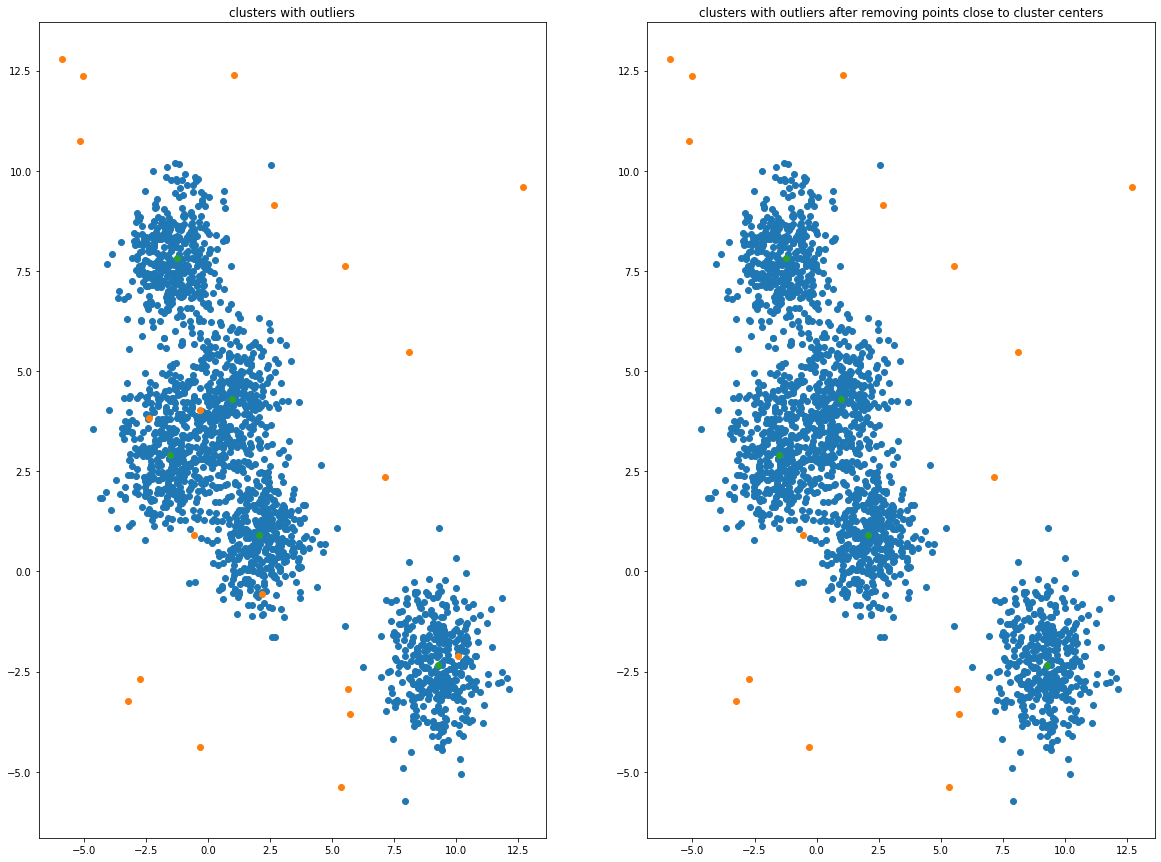

In [ ]:
full_set1, samples1, finalOutliers1 = data_gen(0.01, 5)

##K nearest neighbours

In [ ]:
nearest_neighbours1 = knn(full_set1,10)

###Using method 1 to identify outliers

as i expected, KNN performed fairly well on this dataset as the sparseness of the outliers is taken advantage of by the KNN algorithm

In [ ]:
outliers1, inliers1 = get_outliers_and_inliers(full_set1, nearest_neighbours1, 20)
eval(finalOutliers1, outliers1)

precision: 0.8235294117647058
recall:    0.875
F1 score:  0.8484848484848485


###Using method 2 to identify outliers

Method 2 performs better than method 1. I suspect this is due to the fact that outliers, although spaced out, can still have other outliers that are faily close. This then pulls down the average distance from neighbours of outliers, blurring the line between the average distance of inliers and outliers. Method 2 is effected much less by this problem. This is because its closest neighbours (which could be other outliers) are essentially ignored. Meaning the proximity of other outliers has less of an impact on this method.

In [ ]:
outliers_alt, inliers_alt = get_outliers_alt(full_set1, nearest_neighbours1, 1.7)
eval(finalOutliers1, outliers_alt)

precision: 0.8333333333333334
recall:    0.9375
F1 score:  0.8823529411764706


##OneClassSVM
One class svm works by creating the smallest possible hyperspere containing the inliers. This works well with this dataset as outliers tend to be further away from clusers (you can easily draw a line around clusters that keep outliers on the outside)

novelty detection

In [ ]:
clt_nov1 = one_class_svm_nov(samples1, finalOutliers1, 0.038, 0.3)

errors in train:  59 (4.44947209653092%)
errors in test:  42 (9.021406727828746%)
errors in outliers:  1 (6.25%)


outlier detection

In [ ]:
outliers_svm1, clt_out1 = one_class_svm_out(full_set1, 0.5, 0.5, 0.009)

[45.49588228 67.65794539 66.66583976 ...  1.00000001  1.02844977
  1.4644736 ]


In [ ]:
eval(finalOutliers1, outliers_svm1)

precision: 0.8333333333333334
recall:    0.9375
F1 score:  0.8823529411764706


#Data set 2
* outliers_fraction: 0.05
* num_clusters: 5

in this dataset, there are more outliers compared to dataset 1. This means the outliers will have closer neighbours than the previous dataset and are more densely packed. However, there is still a clear difference between the densisty of inlier clusters and outliers.

total samples: 2000 outliers: 0.05%, outliers expected:100, inliers:1900
blobs: centers: 5, samples = 1900, std dev: 1
clustered samples: 1900
xmin: -4.64, xmax: 13.07
ymin: -5.72, ymax: 10.20
low, high for outliers: -6.30, 14.38
number of outliers produced: 100
outliers distances from centres: mean 5.24, var 3.30
removing 1.01
removing 0.53
removing 0.84
removing 0.42
removing 0.78
removing 1.05
removing 0.39
removing 0.94
removing 0.56
removed 9 outliers. 91 remaining outliers 


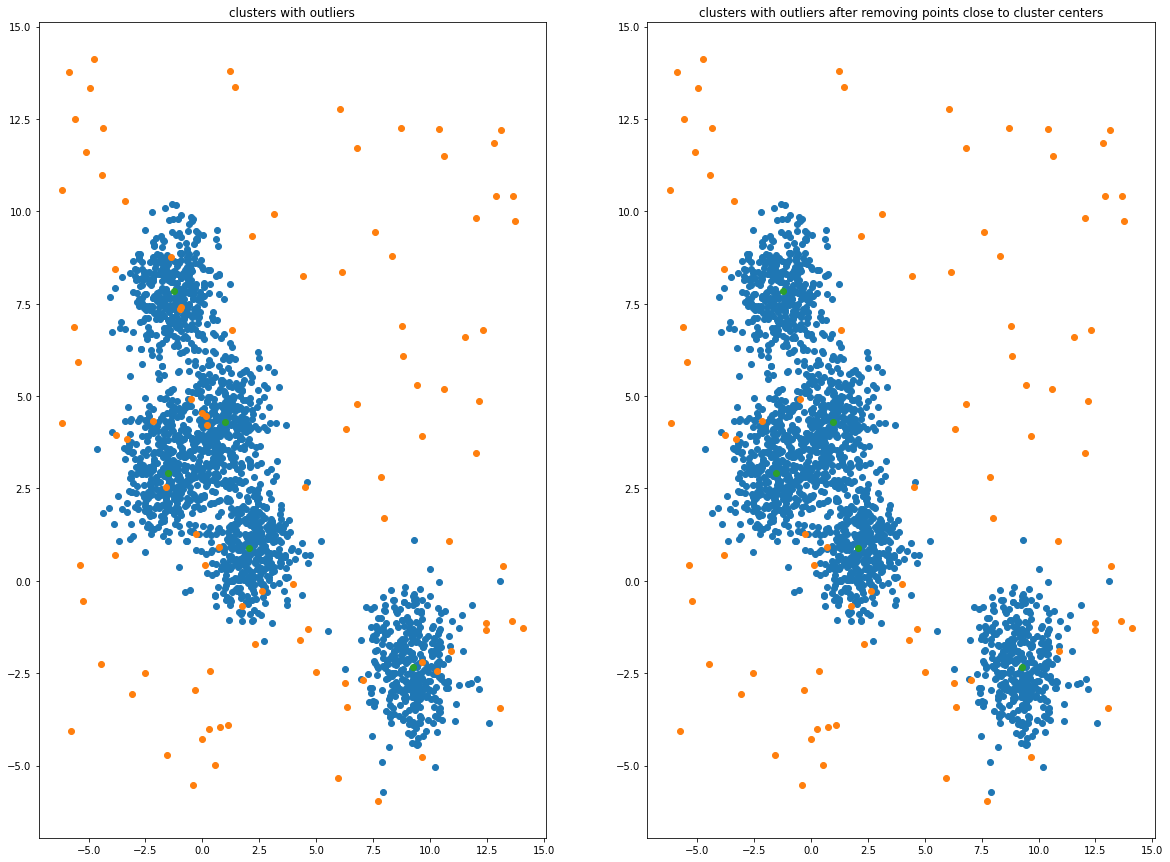

In [ ]:
full_set2, samples2, finalOutliers2 = data_gen(0.05, 5)

##K nearest neighbours

Like last time, method 2 is more effective than method 1. However, both perform slightly worse than last time. This is probably due to the fact that outliers are more densely packed together. This means the distance between neighbours of outliers will be smaller, making it more difficult to distinguish outliers from inliers

In [ ]:
nearest_neighbours2 = knn(full_set2,10)

In [ ]:
outliers2, inliers2 = get_outliers_and_inliers(full_set2, nearest_neighbours2, 10)
eval(finalOutliers2, outliers2)

precision: 0.8505747126436781
recall:    0.8131868131868132
F1 score:  0.8314606741573034


In [ ]:
outliers_alt2, inliers_alt2 = get_outliers_alt(full_set2, nearest_neighbours2, 1.5)
eval(finalOutliers2, outliers_alt2)

precision: 0.9342105263157895
recall:    0.7802197802197802
F1 score:  0.8502994011976048


##OneClassSVM

One class SVM also performed slightly worse than here then on dataset 1. In this data set you can see more outliers mixed in with inliers, especially inbetween clusters whose centres are close togother. This causes problems when creating a hyperspere as consistent division cannot be made. 

novelty detection

In [ ]:
clt_nov2 = one_class_svm_nov(samples2, finalOutliers2, 0.07, 0.15)

errors in train:  89 (6.991358994501179%)
errors in test:  54 (14.19457735247209%)
errors in outliers:  10 (10.989010989010989%)


outlier detection

In [ ]:
outliers_svm2, clt_out2 = one_class_svm_out(full_set2, 0.1, 0.2, 0.05)

[11.8634127  11.88326214 11.82430357 ... 11.82044668  3.06132908
  4.54727666]


In [ ]:
eval(finalOutliers2, outliers_svm2)

precision: 0.77
recall:    0.8461538461538461
F1 score:  0.8062827225130889


#Data set 3
* outliers_fraction: 0.1
* num_clusters: 5

in this data set, we again see an increase in the number of outliers. Meaning the density of outliers will cause more problems for KNN. We can also see more outliers mixing with inliers, this will cause problems for one class SVM

total samples: 2000 outliers: 0.1%, outliers expected:200, inliers:1800
blobs: centers: 5, samples = 1800, std dev: 1
clustered samples: 1800
xmin: -4.64, xmax: 13.07
ymin: -5.05, ymax: 10.17
low, high for outliers: -5.55, 14.38
number of outliers produced: 200
outliers distances from centres: mean 5.35, var 3.47
removing 0.76
removing 0.87
removing 0.60
removing 1.05
removing 0.93
removing 0.38
removing 0.52
removing 0.87
removing 0.99
removing 1.09
removing 0.74
removing 0.60
removed 12 outliers. 188 remaining outliers 


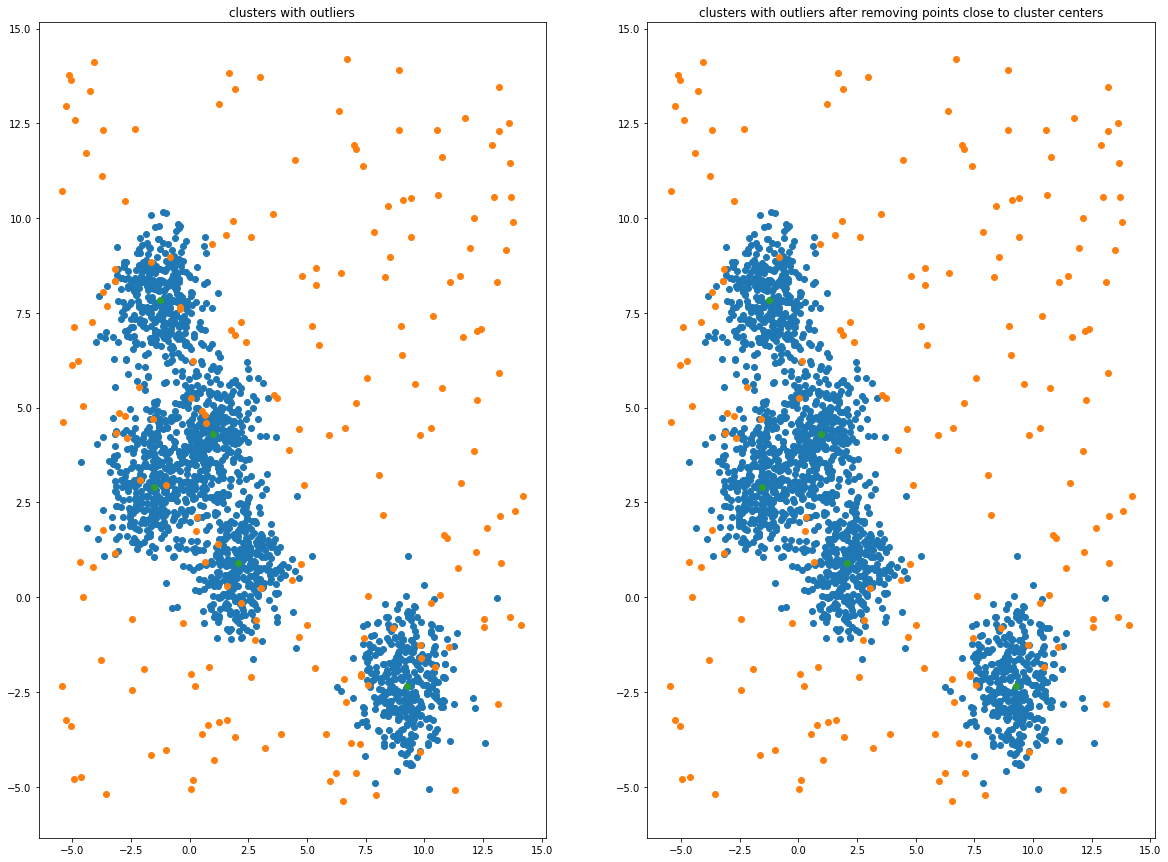

In [ ]:
full_set3, samples3, finalOutliers3 = data_gen(0.1, 5)

##K nearest neighbours

as expected, we see a decrease in performance compared to last time. Due to the same reasons we saw a decrease in performance from dataset 1 to dataset 2

In [ ]:
nearest_neighbours3 = knn(full_set3,10)

In [ ]:
outliers3, inliers3 = get_outliers_and_inliers(full_set3, nearest_neighbours3, 5.6)
eval(finalOutliers3, outliers3)

precision: 0.8315217391304348
recall:    0.8138297872340425
F1 score:  0.8225806451612904


In [ ]:
outliers_alt3, inliers_alt3 = get_outliers_alt(full_set3, nearest_neighbours3, 1)
eval(finalOutliers3, outliers_alt3)

precision: 0.877906976744186
recall:    0.8031914893617021
F1 score:  0.8388888888888889


##OneClassSVM

when it comes to novelty detection, again we see a decrease in performance compared to dataset 2. This is likely due to the amount of outliers that are mixed in with inliers has increased.

novelty detection

In [ ]:
clt_nov3 = one_class_svm_nov(samples3, finalOutliers3, 0.1, 0.08)

errors in train:  120 (9.950248756218906%)
errors in test:  81 (20.2020202020202%)
errors in outliers:  18 (9.574468085106384%)


interestingly, we see an slight increase of performance when using one classSVM for outlier detection. This could be due me getting lucky with the hyper parameter tuning. But this could also be due to the increase of outliers. The model has found that it is more benificial to introduce a small increase in precision (ds 2 - 0.77, ds 3 - 0.78) at the cost of a small decrease in recall (ds 2 - 0.846, ds 3 - 0.835). This likely due to the fact that accepting outliers that are mixed in with inliers will be wrongly classified makes for a better hypersphere that includes more inliers. In other words, the number of inliers that get correctly classified outweighs the number of outliers that get missclassified. 

outlier detection

In [ ]:
outliers_svm3, clt_out3 = one_class_svm_out(full_set3, 0.3, 0.3, 0.1)

[33.85896947 18.82450083 36.96387468 ...  3.35553461  6.05153202
  7.09361058]


note: evaluation records the number of outliers correctly labelled, not inliers.

In [ ]:
eval(finalOutliers3, outliers_svm3)

precision: 0.7889447236180904
recall:    0.8351063829787234
F1 score:  0.8113695090439277


#Data set 4
* outliers_fraction: 0.01
* num_clusters: 10

this dataset is similar to dataset 1 in terms of outlier density. However, we see an increase in the number of inlier clusters.

total samples: 2000 outliers: 0.01%, outliers expected:20, inliers:1980
blobs: centers: 10, samples = 1980, std dev: 1
clustered samples: 1980
xmin: -12.60, xmax: 11.89
ymin: -10.52, ymax: 10.77
low, high for outliers: -13.86, 13.08
number of outliers produced: 20
outliers distances from centres: mean 5.09, var 3.01
removing 0.77
removing 0.63
removed 2 outliers. 18 remaining outliers 


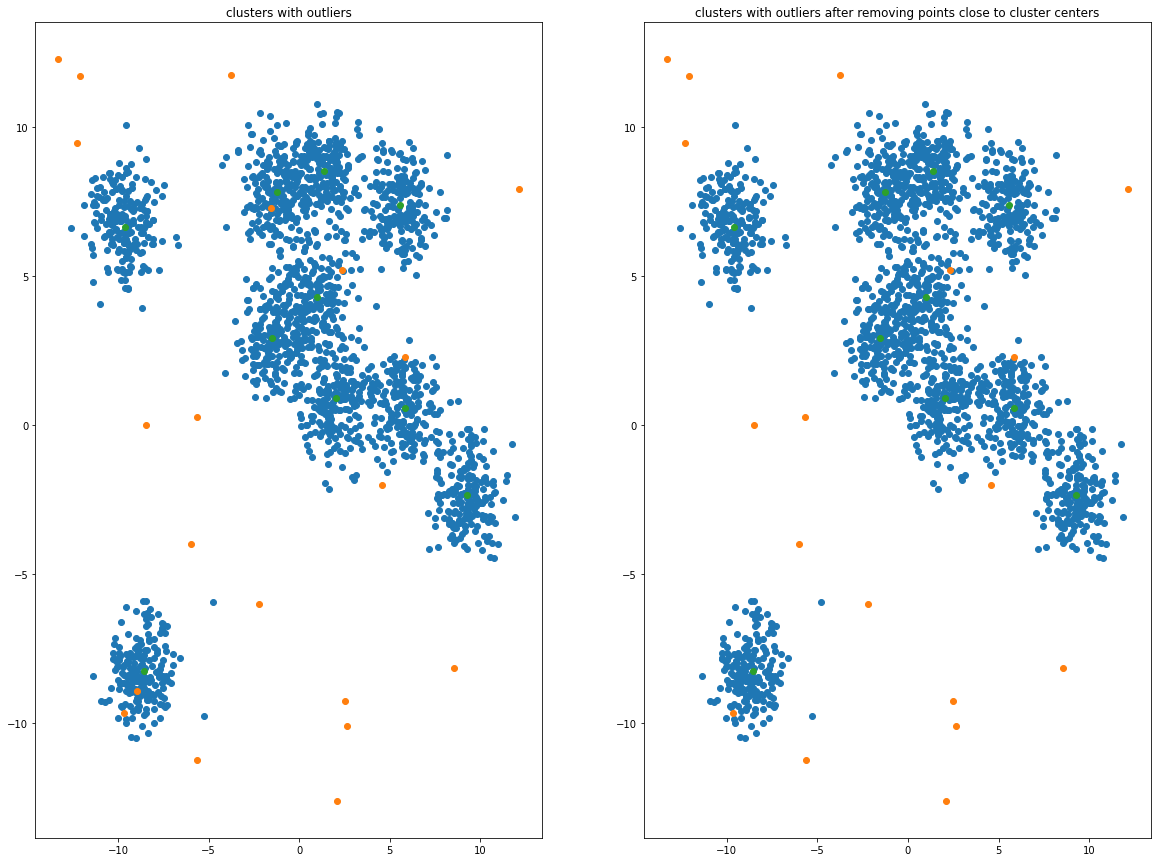

In [11]:
full_set4, samples4, finalOutliers4 = data_gen(0.01, 10)

##K nearest neighbours

compared to dataset 1, we see a decrease in performance. This could be due to parameter tuning. Otherwise im not sure why there is a decrease in performance

In [12]:
nearest_neighbours4 = knn(full_set4,5)

In [20]:
outliers4, inliers4 = get_outliers_and_inliers(full_set4, nearest_neighbours4, 16)
eval(finalOutliers4, outliers4)

precision: 0.875
recall:    0.7777777777777778
F1 score:  0.823529411764706


In [18]:
outliers_alt4, inliers_alt4 = get_outliers_alt(full_set4, nearest_neighbours4, 1.6)
eval(finalOutliers4, outliers_alt4)

precision: 0.875
recall:    0.7777777777777778
F1 score:  0.823529411764706


##OneClassSVM

again, compared to dataset 1, we see a decrease in performance. This could be caused by the increase of clusters. This means when the hyperspheres are created, it is more likely to draw a single hypersphere with more than one cluster inside. This means the sphere cant get as close to the centre of each cluster as it is trying to account for multiple clusters. 

novelty detection

In [ ]:
clt_nov4 = one_class_svm_nov(samples4, finalOutliers4, 0.05, 0.03)

errors in train:  66 (4.97737556561086%)
errors in test:  41 (10.091743119266056%)
errors in outliers:  3 (16.666666666666664%)


outlier detection

In [ ]:
outliers_svm4, clt_out4 = one_class_svm_out(full_set4, 0.1, 0.1, 0.01)

[17.2376988  15.07264727 15.43234553 ...  2.38612699  6.50964612
 13.85072721]


In [ ]:
eval(finalOutliers4, outliers_svm4)

precision: 0.7
recall:    0.7777777777777778
F1 score:  0.7368421052631577


#Data set 5
* outliers_fraction: 0.05
* num_clusters: 10

a simalar change between dataset 1 and dataset 2 can be found here between this dataset and dataset 4. The increased number of clusters is maintained from the last data set.

The models perform surprisingly well with this dataset. I think this may be because out of chance we have generated a dataset with less outliers mixing with inliers in proportion to the number of outliers in total.

total samples: 2000 outliers: 0.05%, outliers expected:100, inliers:1900
blobs: centers: 10, samples = 1900, std dev: 1
clustered samples: 1900
xmin: -11.91, xmax: 11.89
ymin: -10.54, ymax: 10.83
low, high for outliers: -13.10, 13.08
number of outliers produced: 100
outliers distances from centres: mean 4.55, var 2.34
removing 0.87
removing 0.24
removing 0.39
removing 1.58
removing 1.27
removing 1.42
removing 1.14
removing 1.42
removing 1.46
removing 1.60
removing 1.12
removing 1.16
removing 1.20
removing 1.43
removed 14 outliers. 86 remaining outliers 


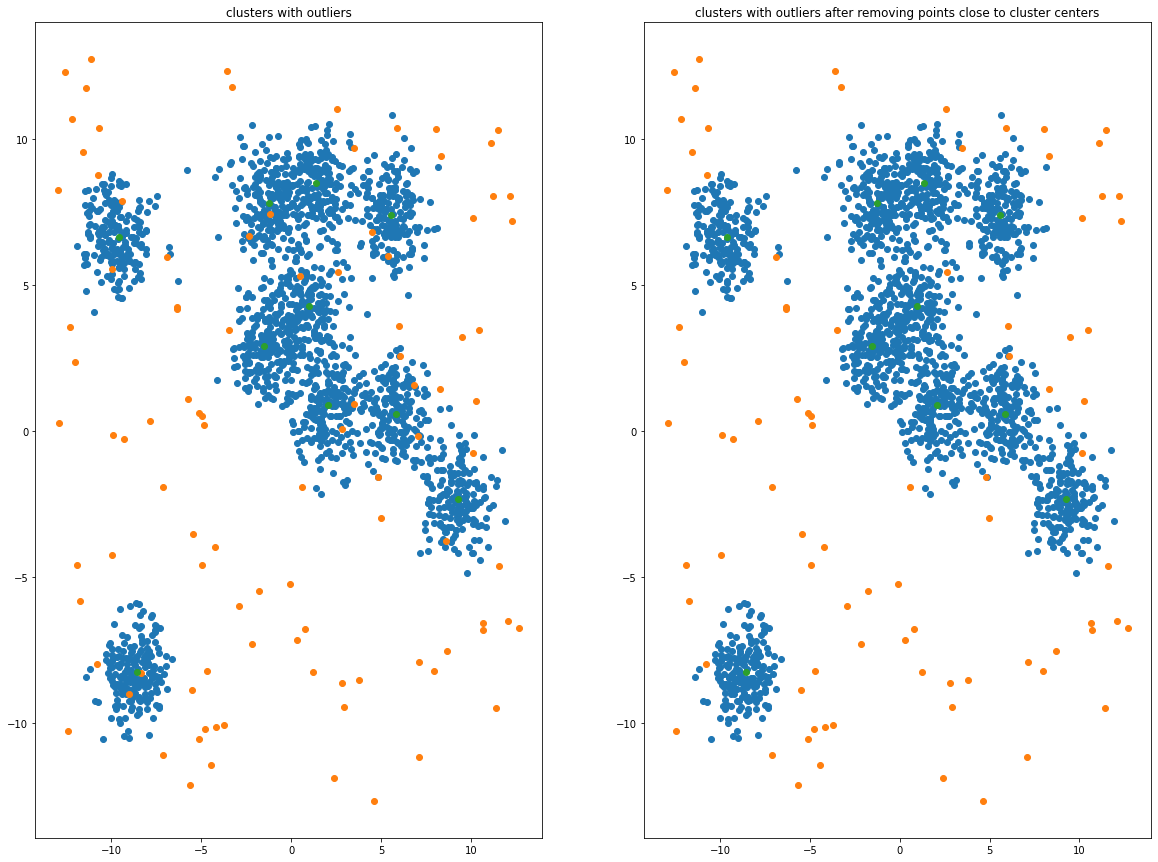

In [ ]:
full_set5, samples5, finalOutliers5 = data_gen(0.05, 10)

##K nearest neighbours

There is an increase in performance compared to KNN in dataset 4, and also dataset 2 (same density of outliers). I believe this is due to the dataset generating fewer outliers mixed in with inliers.

In [ ]:
nearest_neighbours5 = knn(full_set5,10)

In [ ]:
outliers5, inliers5 = get_outliers_and_inliers(full_set5, nearest_neighbours5, 11)
eval(finalOutliers5, outliers5)

precision: 0.9857142857142858
recall:    0.8023255813953488
F1 score:  0.8846153846153846


In [ ]:
outliers_alt5, inliers_alt5 = get_outliers_alt(full_set5, nearest_neighbours5, 1.6)
eval(finalOutliers5, outliers_alt5)

precision: 0.9
recall:    0.8372093023255814
F1 score:  0.8674698795180723


##OneClassSVM

again There is an increase in performance compared to SVM in dataset 4, and also dataset 2 (same density of outliers). I believe this is due to the dataset generating fewer outliers mixed in with inliers.

novelty detection

In [ ]:
clt_nov5 = one_class_svm_nov(samples5, finalOutliers5, 0.06, 0.1)

errors in train:  79 (6.205813040062844%)
errors in test:  37 (12.599681020733652%)
errors in outliers:  4 (4.651162790697675%)


outlier detection

In [ ]:
outliers_svm5, clt_out5 = one_class_svm_out(full_set5, 0.1, 0.1, 0.04)

[12.0744623  11.01650621 11.3485633  ...  6.75286125 10.05615503
  8.70402687]


In [ ]:
eval(finalOutliers5, outliers_svm5)

precision: 0.9
recall:    0.8372093023255814
F1 score:  0.8674698795180723


#Data set 6
* outliers_fraction: 0.1
* num_clusters: 10

total samples: 2000 outliers: 0.1%, outliers expected:200, inliers:1800
blobs: centers: 10, samples = 1800, std dev: 1
clustered samples: 1800
xmin: -12.41, xmax: 11.95
ymin: -10.54, ymax: 10.83
low, high for outliers: -13.65, 13.15
number of outliers produced: 200
outliers distances from centres: mean 4.62, var 2.57
removing 1.50
removing 0.51
removing 0.48
removing 1.23
removing 1.46
removing 1.22
removing 1.14
removing 1.25
removing 1.36
removing 1.29
removing 0.59
removing 1.37
removing 1.51
removing 0.49
removing 0.88
removing 1.20
removing 1.44
removing 0.69
removing 1.07
removing 0.20
removing 1.23
removed 21 outliers. 179 remaining outliers 


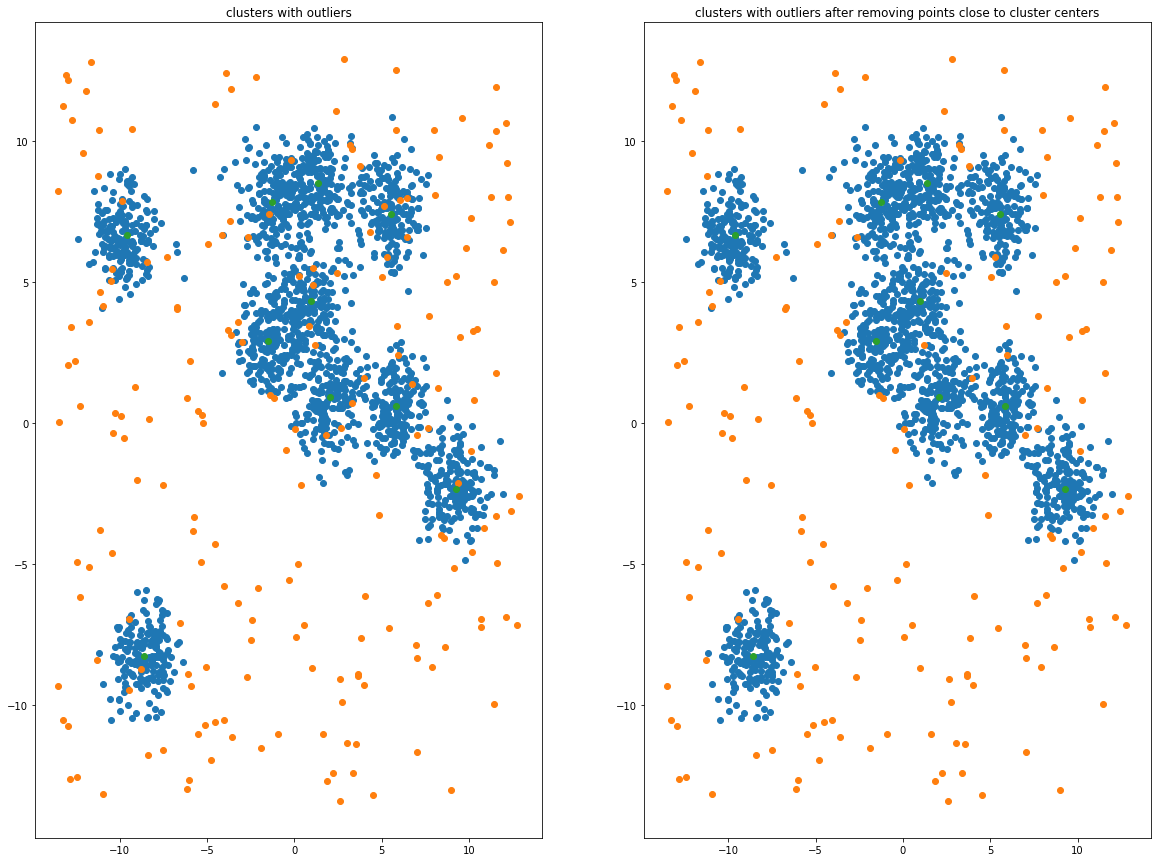

In [ ]:
full_set6, samples6, finalOutliers6 = data_gen(0.1, 10)

##K nearest neighbours

we can see a slight increase in performance compared to dataset 3 (same outlier density). This further demonstrates that KNN is not effected by the number of clusters unlike SVM. I dont believe the increase of clusters has any role in the slight increase in performance.

In [ ]:
nearest_neighbours6 = knn(full_set6,10)

In [ ]:
outliers6, inliers6 = get_outliers_and_inliers(full_set6, nearest_neighbours6, 5.1)
eval(finalOutliers6, outliers6)

precision: 0.8531073446327684
recall:    0.8435754189944135
F1 score:  0.848314606741573


In [ ]:
outliers_alt6, inliers_alt6 = get_outliers_alt(full_set6, nearest_neighbours6, 1.6)
eval(finalOutliers6, outliers_alt6)

precision: 0.9571428571428572
recall:    0.7486033519553073
F1 score:  0.8401253918495297


##OneClassSVM

unlike KNN, we see a slight decrease in performance compared to dataset 3 (same outlier density). i believe this is cause by the same reason stated for the decrease in performance of dataset 4 with SVM.

novelty detection

In [ ]:
clt_nov6 = one_class_svm_nov(samples6, finalOutliers6, 0.05, 0.5)

errors in train:  124 (10.281923714759536%)
errors in test:  93 (20.875420875420875%)
errors in outliers:  21 (11.731843575418994%)


outlier detection

In [ ]:
outliers_svm5, clt_out5 = one_class_svm_out(full_set5, 0.5, 0.1, 0.05)

[95.07475828 75.1715773  85.094079   ... 12.13104692 60.11207108
 25.44127525]


In [ ]:
eval(finalOutliers5, outliers_svm5)

precision: 0.76
recall:    0.8837209302325582
F1 score:  0.8172043010752689


#Conclusion
From these experiments (excluding dataset 5), i have found that an increase number of outliers (and therefore outlier density) causes the performance of both KNN and one class SVM to decline. However, i believe this decrease in performance is caused by slightly different reasons. For KNN, the increase in outlier density brings the distance between outliers and its neighbours down to a similar distance seen between inliers. This causes an increase in confusion between the two. with one class SVM on the other hand, the increases number of outliers means it is more likely that there are more outliers closer to the clusters of inliers. This means that it is more likely that an outlier falls within the boundary of the hypersphere and therefore gets classed as an inlier.

An increase in the number of clusters however does not affect the accuracy of KNN but it does seem to affect one class SVM (excluding dataset 5). The increase in the number of clusters means clusters are more likely to be closer together. This means when the hyperspheres are created, it is more likely to draw a single hypersphere with more than one cluster inside. This means the sphere cant get as close to the centre of each cluster as it is trying to account for multiple clusters. I believe this causes the missclassification of inliers/outliers and therfore a decrease in performance.

Overall, i think KNN is a more well rounded outlier detection method as both KNN and one class SVM performed similarly in datasets 1-3 but KNN out performed SVM in datasets 4-6.